In [13]:
import argparse
import os
import yaml
import uproot
import numpy as np
import pandas as pd
import sys
from particle import Particle
import copy
sys.path.insert(0, '..')

def loadAO2D(inFileNames, inTreeName):
    '''
    utility to load tree from AO2D and return its content in a dataframe
    '''
    dataframe = pd.DataFrame()
    if not isinstance(inFileNames, list):
            inFileNames = [inFileNames]
    for file in inFileNames:
        print(f'Loading trees form {file}')
        f = uproot.open(file)
        dirnames = f.keys(recursive = False)
        print(f"keys found in file: {dirnames}")
        for dirname in dirnames:
            if 'DF' in dirname:
                path = f'{file}:{dirname}/{inTreeName}'
                dataframe = pd.concat([dataframe, uproot.open(path).arrays(library='pd')], ignore_index=True)
                print(f"processed key: {dirname}")
            else:
                continue
    return dataframe
    
configfile = '/home/luca/alice/CharmResonancesAnalysis/configs/config_Ds2Star_triggers.yml'
with open(configfile, 'r') as ymlCfgFile:
        cfg = yaml.load(ymlCfgFile, yaml.FullLoader)

dataFileName = cfg['fileNameData']
inTreeNameData = cfg['treeNameData']
dfData = loadAO2D(dataFileName, inTreeNameData)

Loading trees form /home/luca/alice/CharmResonancesAnalysis/data/AO2D_Ds2Star_Trg.root
keys found in file: ['DF_2263624354520192;1', 'DF_2263916065959424;1', 'DF_2267291922397184;1', 'DF_2298103943798048;1', 'DF_2298168381008160;1', 'DF_2300577908982464;1', 'DF_2302098241598368;1', 'DF_2302098641774816;1', 'DF_2302338756617184;1', 'DF_2302557844718752;1', 'DF_2302859424692544;1', 'DF_2303112496234368;1', 'DF_2305723513620224;1', 'DF_2308562257543200;1', 'DF_2308948875187328;1', 'DF_2317062262224640;1', 'DF_2304198644192768;1', 'DF_2304709555078176;1', 'DF_2305495560850816;1', 'DF_2305959546460512;1', 'DF_2307574351125248;1', 'DF_2308326141539296;1', 'DF_2308390591318496;1', 'DF_2308592563440480;1', 'DF_2308755674180544;1', 'DF_2308996353111456;1', 'DF_2309168304528608;1', 'DF_2309700453693472;1', 'DF_2309949911836608;1', 'DF_2310095824192864;1', 'DF_2310314828739168;1', 'DF_2310533953137440;1', 'DF_2263692636163456;1', 'DF_2267189063004288;1', 'DF_2267309224568448;1', 'DF_2269722724828

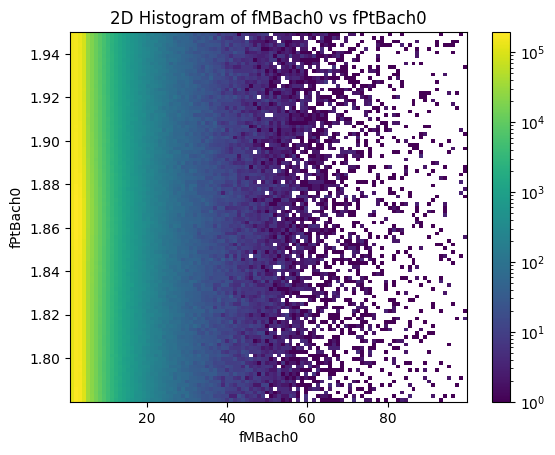

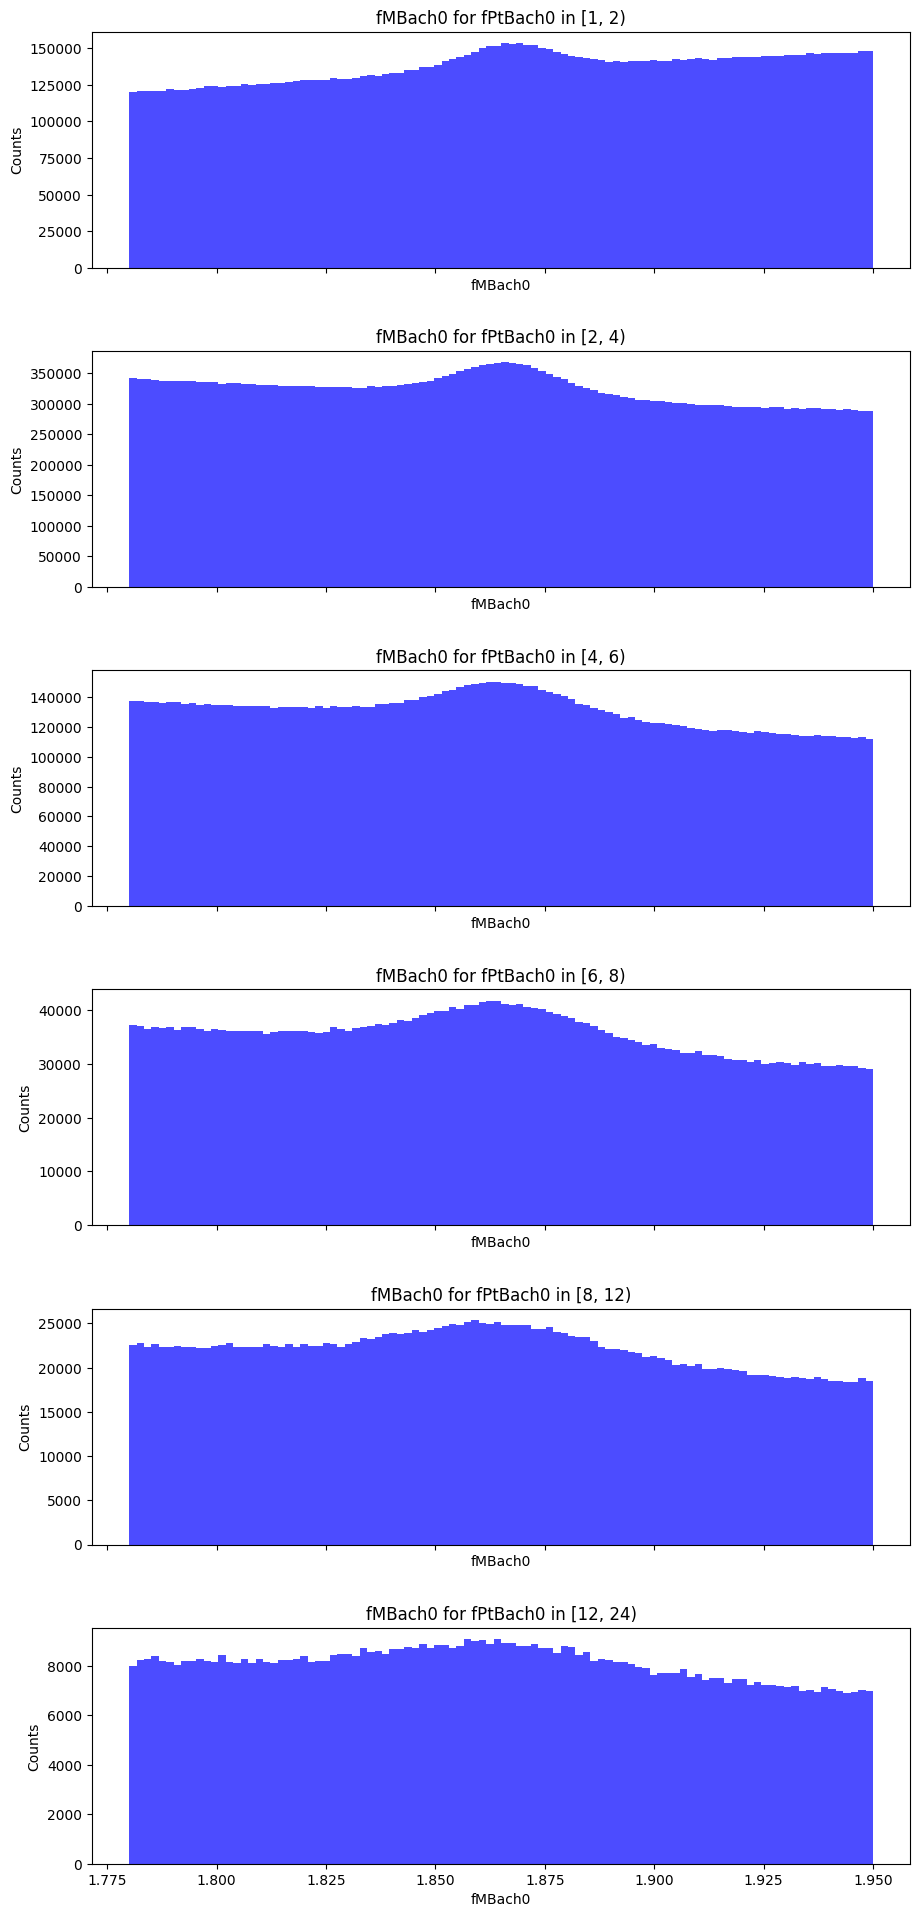

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Assuming dfData is a pandas DataFrame and has columns 'fMBach0' and 'fPtBach0'
plt.hist2d(dfData['fPtBach0'], dfData['fMBach0'], bins=[100, 100], cmap='viridis', norm=LogNorm())
plt.colorbar()
plt.xlabel('fMBach0')
plt.ylabel('fPtBach0')
plt.title('2D Histogram of fMBach0 vs fPtBach0')
plt.show()

# Define the intervals for fPtBach0
intervals = [(1, 2), (2, 4), (4, 6), (6, 8), (8, 12), (12, 24)]

# Plot histograms of fMBach0 for each interval of fPtBach0
fig, axes = plt.subplots(len(intervals), 1, figsize=(10, 20), sharex=True)
fig.tight_layout(pad=5.0)

for i, (low, high) in enumerate(intervals):
    df_interval = dfData[(dfData['fPtBach0'] >= low) & (dfData['fPtBach0'] < high)]
    axes[i].hist(df_interval['fMBach0'], bins=100, color='blue', alpha=0.7)
    axes[i].set_title(f'fMBach0 for fPtBach0 in [{low}, {high})')
    axes[i].set_xlabel('fMBach0')
    axes[i].set_ylabel('Counts')

plt.show()

In [15]:
def applyParametrizedMassCut(df, cfg):
    '''
    utility to apply parametrized invariant mass cut (for D+ bachelor)
    '''
    cutVars = cfg['cutVars']
    ptLabel = cutVars['ptBach0']['varname']
    params = cutVars['invMassProng0']['params']
    massLabel = cutVars['invMassProng0']['varname']

    pdgMass = 1.8697
    # Compute peakMean
    peakMean = np.where(
        df[ptLabel] < params['ptMaxDelta'],
        (pdgMass + params['deltaMassConst'] +
        params['deltaMassLinear'] * df[ptLabel]),
        pdgMass
    )

    # Compute peakWidth
    peakWidth = (params['sigmaConst'] +
                params['sigmaLinear'] * df[ptLabel])

    # Final condition
    df['pass_cut'] = ~(np.abs(df[massLabel] - peakMean) >
                        params['nSigma'] * peakWidth)

    # Filter rows that pass the cut
    dfOut = df[df['pass_cut']]

    return dfOut

def applySelections(dfIn, cfg, isMC = False):
    '''
    utility to apply pt differential cuts on dataframes
    '''
    # TO DO: add BDT selections as a function of pt of D-meson not resonance
    cutVars = cfg['cutVars']
    ptLabel = cutVars['pt']['varname']
    selectedFlags = cfg['acceptFlags']
    dfOut = pd.DataFrame()
    dfFiltered = pd.DataFrame()
    # Selection on candidate type:
    if isMC:
        for flag in selectedFlags:
            dfPart = dfIn[np.abs(dfIn["fFlagMcMatchRec"]) == flag]
            dfFiltered = pd.concat([dfFiltered, dfPart])
    else:
        dfFiltered = dfIn
    # cuts differential in bachelor pT
    print(f"Starting Number of candidates: {len(dfFiltered)}")
    dfBachCut = pd.DataFrame()
    alreadyCut = []
    if cutVars['invMassProng0']['parametrized']:
        print("Applying parametrized mass cut for D+")
        dfProv = pd.DataFrame()
        dfProv = applyParametrizedMassCut(dfFiltered, cfg)
        alreadyCut.append('invMassProng0')
        dfFiltered = dfProv
    for iPtBach0, (ptMinBach0, ptMaxBach0) in enumerate(zip(cutVars['ptBach0']['min'], cutVars['ptBach0']['max'])):
        dfCut = dfFiltered[(dfFiltered[f"{cutVars['ptBach0']['varname']}"] >= ptMinBach0) & (dfFiltered[f"{cutVars['ptBach0']['varname']}"] < ptMaxBach0)]
        for var in cutVars:
            if not cutVars[var]['useBachPt'] or var == 'ptBach0':
                continue
            if var == 'invMassProng0':
                if cutVars[var]['parametrized']:
                    continue
            varMin = cutVars[var]['min'][iPtBach0]
            varMax = cutVars[var]['max'][iPtBach0]
            varLabel = cutVars[var]['varname']
            if varMin is not None:
                # print(f'cutting on {var} > {varMin} for pT Bachelor {ptMinBach0}-{ptMaxBach0}')
                dfCut = dfCut[dfCut[f"{varLabel}"] >= varMin]
                alreadyCut.append(var)
            if varMax is not None:
                # print(f'cutting on {var} < {varMax} for pT Bachelor {ptMinBach0}-{ptMaxBach0}')
                dfCut = dfCut[dfCut[f"{varLabel}"] < varMax]
                alreadyCut.append(var)
        dfBachCut = pd.concat([dfBachCut, dfCut])
    # cuts differential in candidate pT
    for iPt, (ptMin, ptMax) in enumerate(zip(cutVars['pt']['min'], cutVars['pt']['max'])):
        dfCut = dfBachCut[(dfBachCut[f"{ptLabel}"] >= ptMin) & (dfBachCut[f"{ptLabel}"] < ptMax)]
        for var in cutVars:
            if var == 'pt' or var in alreadyCut or var == 'ptBach0':
                continue
            varMin = cutVars[var]['min'][iPt]
            varMax = cutVars[var]['max'][iPt]
            varLabel = cutVars[var]['varname']
            if varMin is not None:
                # print(f'cutting on {var} > {varMin} for pT Candidate {ptMin}-{ptMax}')
                dfCut = dfCut[dfCut[f"{varLabel}"] >= varMin]
            if varMax is not None:
                # print(f'cutting on {var} < {varMax} for pT Candidate {ptMin}-{ptMax}')
                dfCut = dfCut[dfCut[f"{varLabel}"] < varMax]
        dfOut = pd.concat([dfOut, dfCut])
    print(f"Kept {len(dfOut)} candidates")
    return dfOut

Starting Number of candidates: 65967158
Kept 56347630 candidates


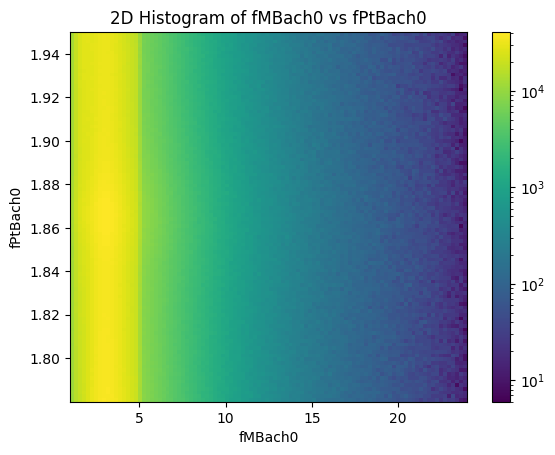

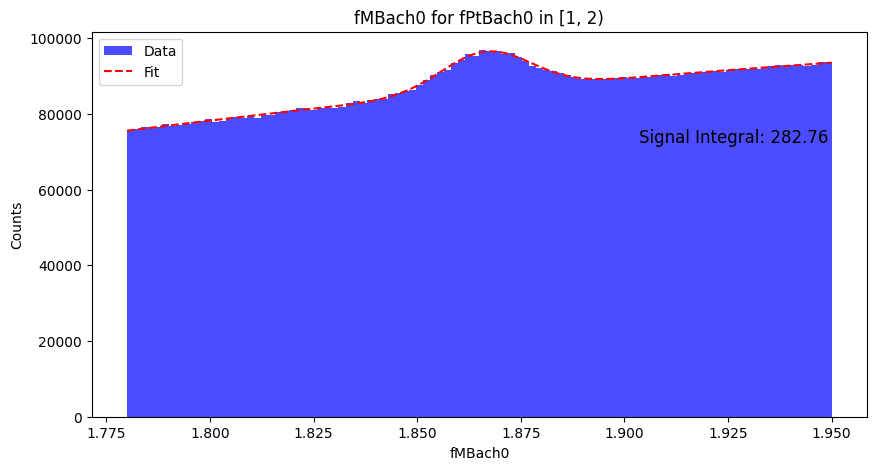

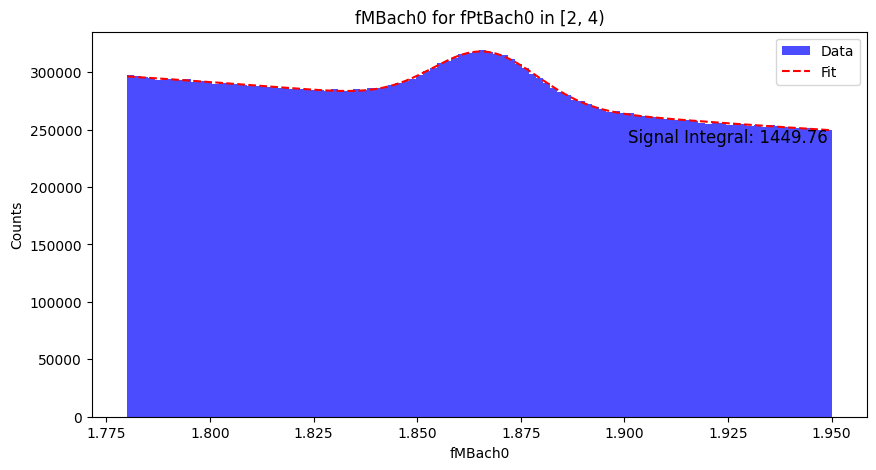

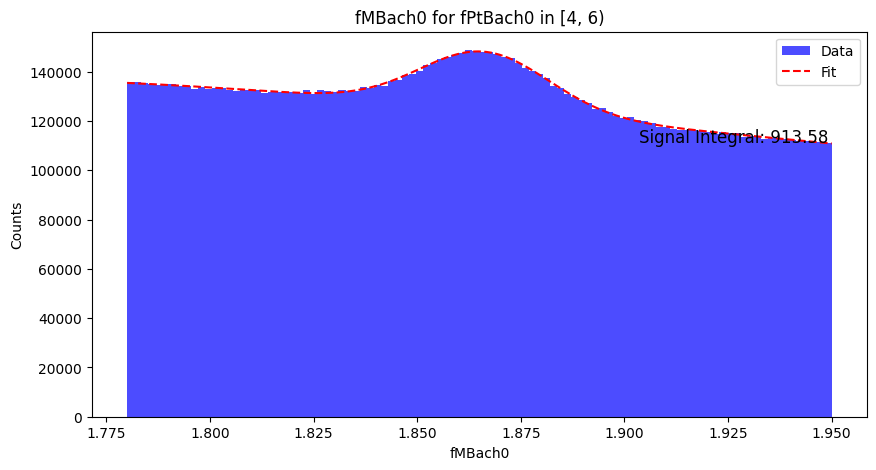

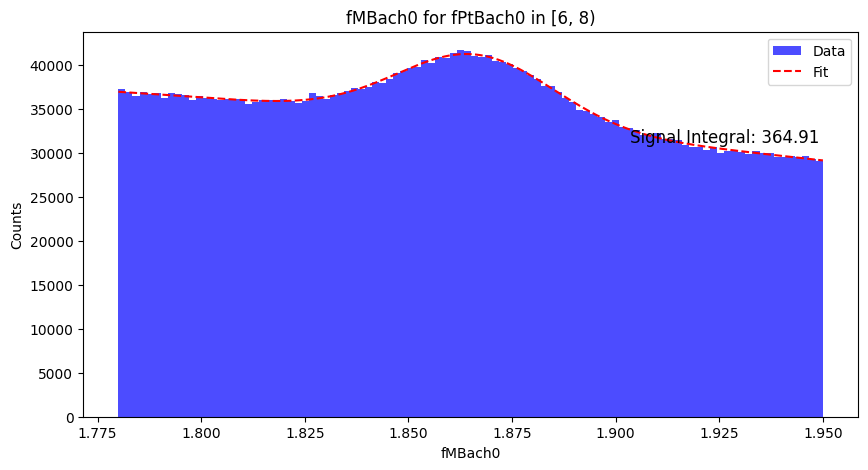

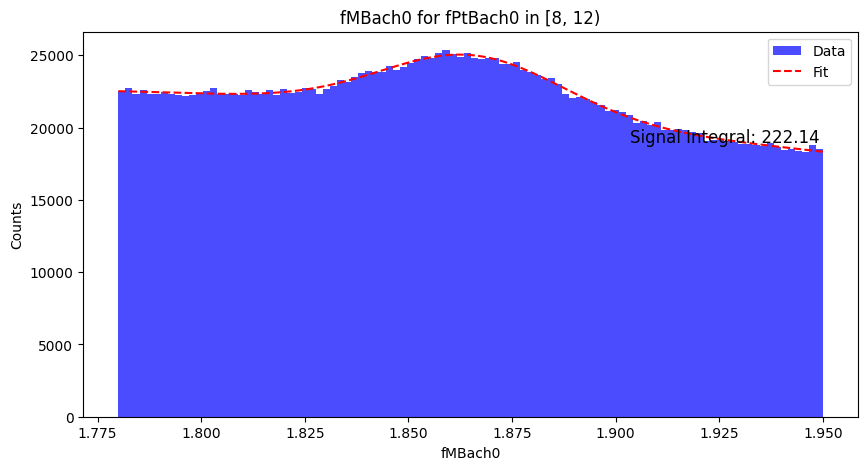

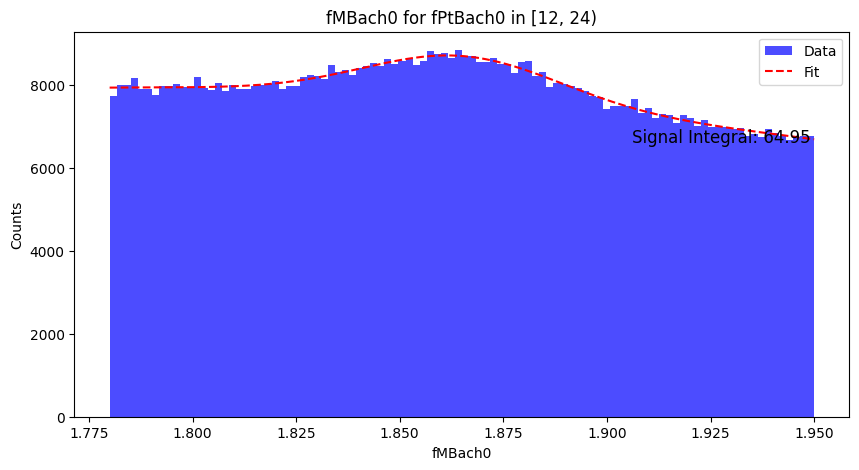

In [ ]:
from scipy.optimize import curve_fit

dfFiltered = applySelections(dfData, cfg)
# Assuming dfData is a pandas DataFrame and has columns 'fMBach0' and 'fPtBach0'
plt.hist2d(dfFiltered['fPtBach0'], dfFiltered['fMBach0'], bins=[100, 100], cmap='viridis', norm=LogNorm())
plt.colorbar()
plt.xlabel('fMBach0')
plt.ylabel('fPtBach0')
plt.title('2D Histogram of fMBach0 vs fPtBach0')
plt.show()

# Define the intervals for fPtBach0
intervals = [(1, 2), (2, 4), (4, 6), (6, 8), (8, 12), (12, 24)]

# Define the Gaussian + pol3 function
def gauss_pol3(x, a, x0, sigma, p0, p1, p2, p3):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + p0 + p1 * x + p2 * x**2 + p3 * x**3

# Plot histograms of fMBach0 for each interval of fPtBach0
for i, (low, high) in enumerate(intervals):
    df_interval = dfFiltered[(dfFiltered['fPtBach0'] >= low) & (dfFiltered['fPtBach0'] < high)]
    
    # Create a new figure for each histogram
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot the histogram
    counts, bins, _ = ax.hist(df_interval['fMBach0'], bins=100, color='blue', alpha=0.7, label='Data')
    
    # Fit the histogram with the Gaussian + pol3 function
    bin_centers = (bins[:-1] + bins[1:]) / 2
    popt, _ = curve_fit(gauss_pol3, bin_centers, counts, p0=[max(counts), bin_centers[np.argmax(counts)], 0.1, 1, 1, 1, 1])
    
    # Plot the fit
    x_fit = np.linspace(bins[0], bins[-1], 1000)
    y_fit = gauss_pol3(x_fit, *popt)
    ax.plot(x_fit, y_fit, 'r--', label='Fit')
    
    # Normalize the histogram
    bin_width = bins[1] - bins[0]
    total_entries = len(df_interval['fMBach0'])
    normalized_counts = counts / (total_entries * bin_width)
    
    # Fit the normalized histogram with the Gaussian + pol3 function
    popt, _ = curve_fit(gauss_pol3, bin_centers, normalized_counts, p0=[max(normalized_counts), bin_centers[np.argmax(normalized_counts)], 0.1, 1, 1, 1, 1])
    
    # Plot the fit
    y_fit = gauss_pol3(x_fit, *popt)
    ax.plot(x_fit, y_fit, 'r--', label='Fit')
    
    # Estimate the integral of the signal
    a, x0, sigma, p0, p1, p2, p3 = popt
    signal_integral = a * sigma * np.sqrt(2 * np.pi) * total_entries * bin_width
    
    # Estimate the integral of the background
    background_integral = np.trapz(p0 + p1 * x_fit + p2 * x_fit**2 + p3 * x_fit**3, x_fit) * total_entries * bin_width
    
    # Compare the sum of the integrals to the total number of entries
    total_integral = signal_integral + background_integral
    
    # Add text with the integral information
    ax.text(0.95, 0.75, f'Signal Integral: {signal_integral:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
    ax.text(0.95, 0.65, f'Background Integral: {background_integral:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
    ax.text(0.95, 0.55, f'Total Integral: {total_integral:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
    ax.text(0.95, 0.45, f'Total Entries: {total_entries}', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
    
    
    # Set titles and labels
    ax.set_title(f'fMBach0 for fPtBach0 in [{low}, {high})')
    ax.set_xlabel('fMBach0')
    ax.set_ylabel('Counts')
    ax.legend()
    
    # Show the plot
    plt.show()